In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

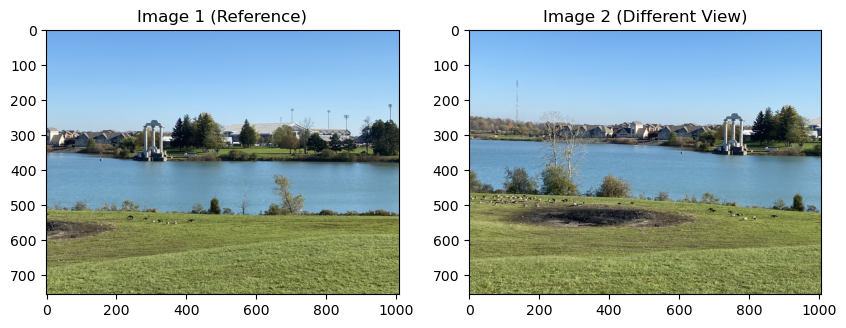

In [23]:
img1 = cv.cvtColor(cv.imread('data/stitch_right.jpg'), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread('data/stitch_left.jpg'), cv.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('Image 1 (Reference)')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('Image 2 (Different View)')
plt.show()

In [15]:
# extract SIFT features
sift = cv.SIFT_create()

# SIFT descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# match features using FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
matcher = cv.FlannBasedMatcher(index_params, search_params)
matches = matcher.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good_matches = []
for m_n in matches:
    m, n = m_n
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Found {len(good_matches)} good matches.")

Found 935 good matches.


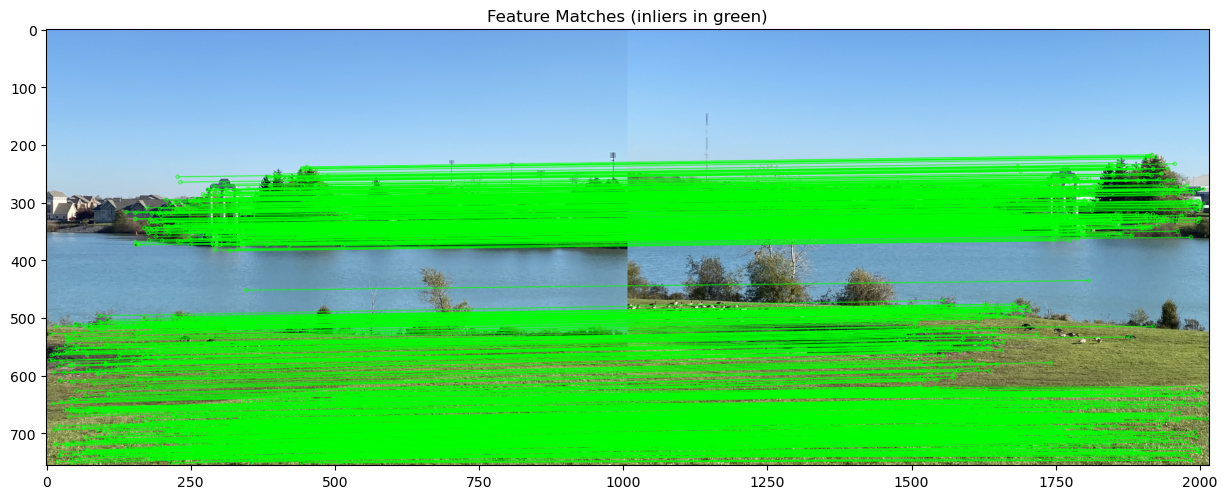

In [30]:
# Estimate Homography with RANSAC 
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0) # Compute Homography
matches_mask = mask.ravel().tolist()

# Display inlier matches
draw_params = dict(matchColor=(0,255,0), singlePointColor=None, matchesMask=matches_mask, flags=2)
matched_img = cv.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

plt.figure(figsize=(15, 7))
plt.imshow(matched_img)
plt.title("Feature Matches (inliers in green)")
plt.show()

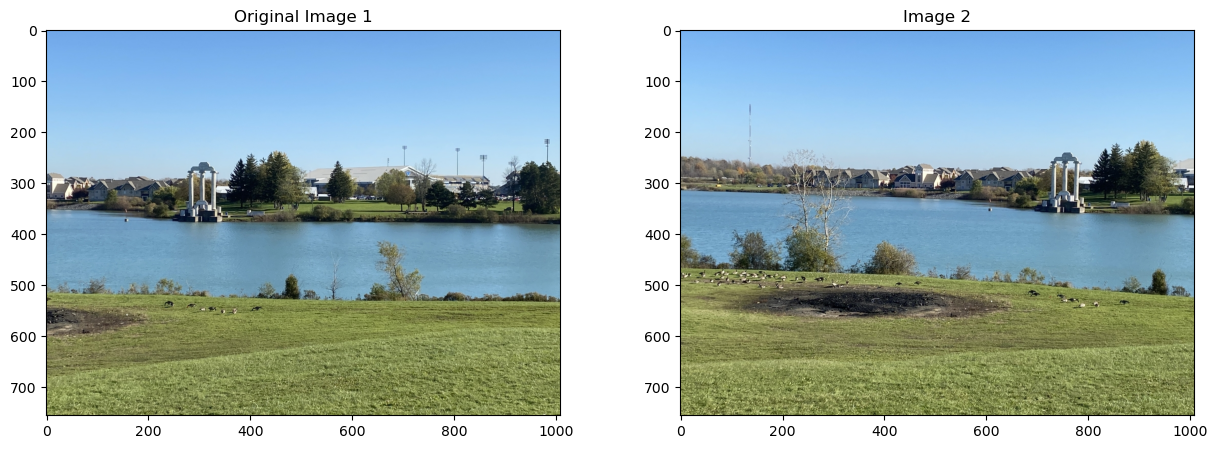

(756, 1008, 3)


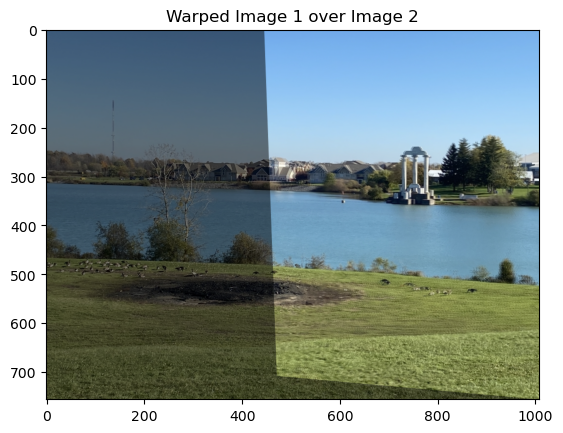

In [29]:
# Warp image 1 onto image 2's plane
h2, w2 = img2.shape[:2]
warped_img1 = cv.warpPerspective(img1, H, (w2, h2))

# Overlay results
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('Original Image 1')
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('Image 2')
plt.show()

blended = cv.addWeighted(img2, 0.5, warped_img1, 0.5, 0)
plt.imshow(blended)
print(blended.shape)
plt.title('Warped Image 1 over Image 2')
plt.show()

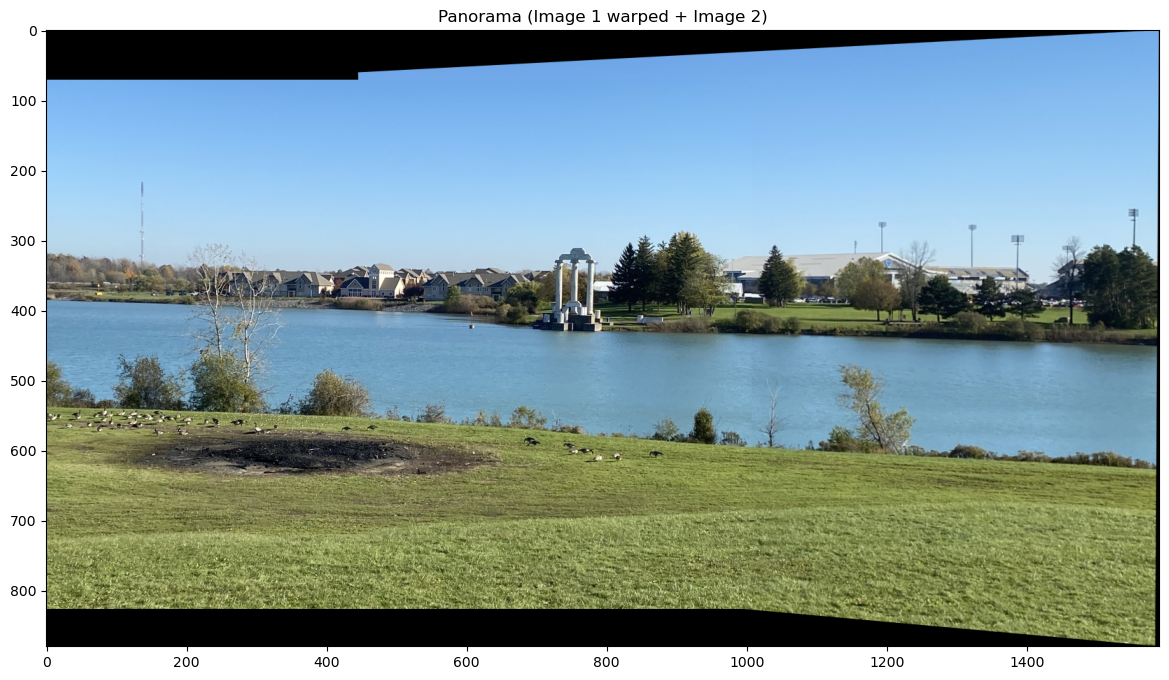

In [31]:
# if you want to show the entire panorama image,
# compute where the corners of img1 map to in img2 coordinates
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

corners_img1 = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2)
warped_corners = cv.perspectiveTransform(corners_img1, H)

# Combine both sets of corners to find the full panorama extents
all_corners = np.concatenate((warped_corners, np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)), axis=0)
[xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

# Compute translation to avoid negative coordinates
translation = [-xmin, -ymin]
T = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]])

# Warp img1 into the panorama canvas
result = cv.warpPerspective(img1, T @ H, (xmax - xmin, ymax - ymin))

# Paste img2 into the panorama
result[translation[1]:h2 + translation[1], translation[0]:w2 + translation[0]] = img2

plt.figure(figsize=(15,8))
plt.imshow(result)
plt.title("Panorama (Image 1 warped + Image 2)")
plt.show()